Colton Morley

Solar Power Generation Forecast

CS458 Fall 2021


Below are all the imports used throughout the project

In [61]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR


Below, the data is converted to a pandas dataframe, and a new column is added that represents the solar power produced 24 hours after the measurements of these variables were taken, they are also split into test and training sets based on the timestamp.

In [62]:
df = pd.read_csv("Solar.csv") #index_col = ZONEID to get rid of numbering
df=df.rename(columns ={
    'ZONEID':'ZONEID',
    'TIMESTAMP':'TIMESTAMP',
    'VAR78':'liquid_water',
    'VAR79':'ice_water',
    'VAR134':'surface_pressure',
    'VAR157':'relative_humidity',
    'VAR164':'cloud_cover',
    'VAR165':'u_wind_component',
    'VAR166':'v_wind_component',
    'VAR167':'two_m_temp',
    'VAR169':'solar_rad_down',
    'VAR175':'thermal_rad_down',
    'VAR178':'net_solar_rad',
    'VAR228':'total_precip',
    'CURR_POWER':'POWER'
})

#Create new df to store 24 hour ahead power
next24_power = df.iloc[:,-1]
#Shift all down 24 hours (1 hour increments)
next24_power = next24_power.shift(periods=-24) #fill_value = 0
#Trim off the old rows that we won't have complete data for
next24_power = next24_power.iloc[:-24]
df = df.iloc[:-24, :]
#Add a new column to the original datafram, holding 24hour ahead power level
df['24Ahead'] = next24_power
df_train = df[df['TIMESTAMP'] <= '20130701 00:00']
df_test = df[df['TIMESTAMP'] >= '20130701 01:00']
#df_train['TIMESTAMP'] = pd.to_datetime(df_train['TIMESTAMP']).view(dtype = np.int64)
#df_test['TIMESTAMP'] = pd.to_datetime(df_test['TIMESTAMP']).view(dtype = np.int64)
#df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']).view(dtype = np.int64)
#df_train
#df_test
df_train.to_csv('SolarTrainingData.csv')
df_test.to_csv('SolarTestingData.csv')
df.head(10)


,ZONEID,TIMESTAMP,liquid_water,ice_water,surface_pressure,relative_humidity,cloud_cover,u_wind_component,v_wind_component,two_m_temp,solar_rad_down,thermal_rad_down,net_solar_rad,total_precip,POWER,24Ahead
0,1,20120401 01:00,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2577830.0,1202532.0,2861797.0,0.000000,0.754103,0.656859
1,1,20120401 02:00,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5356093.0,2446757.0,5949378.0,0.000000,0.555000,0.771410
2,1,20120401 03:00,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7921788.0,3681336.0,8939176.0,0.001341,0.438397,0.613782
3,1,20120401 04:00,0.057167,0.110645,94704.0625,67.775284,0.965866,3.106102,-1.446051,293.261475,9860520.0,4921504.0,11331679.0,0.002501,0.145449,0.554808
4,1,20120401 05:00,0.051027,0.189560,94675.0000,70.172989,0.944669,2.601146,-1.904493,292.732910,11143097.0,6254380.0,13105558.0,0.003331,0.111987,0.458910
5,1,20120401 06:00,0.036996,0.099045,94676.9375,72.374039,0.641353,1.333368,-1.728431,292.077148,11815767.0,7558415.0,14198503.0,0.003960,0.057244,0.198269
6,1,20120401 07:00,0.080911,0.121323,94708.0625,81.798737,0.753142,1.457923,-1.034620,291.069336,12274591.0,8798617.0,14925342.0,0.004970,0.088718,0.085064
7,1,20120401 08:00,0.036159,0.139069,94748.8125,87.854065,0.788338,2.374826,-1.089040,289.073486,12351290.0,10041167.0,15112951.0,0.006477,0.030064,0.011474
8,1,20120401 09:00,0.036372,0.072609,94785.8125,88.793488,0.502275,1.985531,-0.963010,288.031250,12351290.0,11257316.0,15112951.0,0.006725,0.000128,0.000128
9,1,20120401 10:00,0.014353,0.035797,94817.7500,90.450668,0.501918,1.999518,-0.930320,287.405762,12351290.0,12460132.0,15112951.0,0.006745,0.000000,0.000000


Below is a chart that represents the correlations between all the variables in the dataframe.  The column of interest is the 24ahead column that represents affects variables have on the next day's power generation.

In [63]:
#plt.matshow(df.corr())
#plt.show()
#Create Correlation Chart of all vairables
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,ZONEID,liquid_water,ice_water,surface_pressure,relative_humidity,cloud_cover,u_wind_component,v_wind_component,two_m_temp,solar_rad_down,thermal_rad_down,net_solar_rad,total_precip,POWER,24Ahead
ZONEID,1.000000,0.012361,0.002691,-0.808468,-0.001504,0.023025,-0.021821,0.019940,-0.065529,-0.005206,-0.018856,-0.000201,0.010618,0.036821,0.036877
liquid_water,0.012361,1.000000,0.526482,-0.099444,0.252102,0.388763,-0.092982,-0.017153,0.035287,-0.196879,0.069498,-0.136366,0.501401,-0.094911,-0.010176
ice_water,0.002691,0.526482,1.000000,-0.102362,0.135749,0.404612,-0.013819,-0.079427,0.074577,-0.145408,0.001658,-0.100648,0.363377,-0.089537,0.000464
surface_pressure,-0.808468,-0.099444,-0.102362,1.000000,0.093981,-0.087679,-0.221645,0.143801,-0.063772,-0.037682,0.020126,-0.060863,-0.125619,-0.044906,-0.066715
relative_humidity,-0.001504,0.252102,0.135749,0.093981,1.000000,0.282252,-0.195589,0.202117,-0.656238,-0.249049,0.454348,-0.190162,0.276795,-0.612078,-0.543347
cloud_cover,0.023025,0.388763,0.404612,-0.087679,0.282252,1.000000,-0.056754,-0.087482,0.025744,-0.254669,0.083902,-0.192810,0.252218,-0.132045,-0.045203
u_wind_component,-0.021821,-0.092982,-0.013819,-0.221645,-0.195589,-0.056754,1.000000,-0.448655,-0.077921,-0.192625,-0.186421,-0.226072,-0.038059,0.187797,0.188370
v_wind_component,0.019940,-0.017153,-0.079427,0.143801,0.202117,-0.087482,-0.448655,1.000000,-0.268060,0.048503,0.174660,0.063596,0.056682,-0.203125,-0.193966
two_m_temp,-0.065529,0.035287,0.074577,-0.063772,-0.656238,0.025744,-0.077921,-0.268060,1.000000,0.303799,-0.205262,0.325518,-0.018644,0.482477,0.452783
solar_rad_down,-0.005206,-0.196879,-0.145408,-0.037682,-0.249049,-0.254669,-0.192625,0.048503,0.303799,1.000000,0.410128,0.984367,-0.187168,-0.126365,-0.162627


Split the data into zones and do some preprocessing

In [64]:
#print(df_train.columns)
#Dropping timestamp for scaling, but save timestamp columns for later use in analysis
Z1_times = df_test[(df_test['ZONEID']== 1)]
Z1_times = Z1_times['TIMESTAMP']


Z2_times = df_test[(df_test['ZONEID']== 2)]
Z2_times = Z2_times['TIMESTAMP']

Z3_times = df_test[(df_test['ZONEID']== 3)]
Z3_times = Z3_times['TIMESTAMP']


df_train.drop('TIMESTAMP', 1, inplace = True)
df_test.drop('TIMESTAMP', 1, inplace = True)

In [65]:
#Split training and test DataFrames into zones
Z1_train = df_train[(df_train['ZONEID']== 1)]
Z2_train = df_train[(df_train['ZONEID']== 2)]
Z3_train = df_train[(df_train['ZONEID']== 3)]

Z1_test = df_test[(df_test['ZONEID']== 1)]
Z2_test = df_test[(df_test['ZONEID']== 2)]
Z3_test = df_test[(df_test['ZONEID']== 3)]

#Seperate X and Y values
X_train1 = Z1_train.iloc[:, :-1]
X_train2 = Z2_train.iloc[:, :-1]
X_train3 = Z3_train.iloc[:, :-1]

y_train1 = Z1_train.iloc[:, -1]
y_train2 = Z2_train.iloc[:, -1]
y_train3 = Z3_train.iloc[:, -1]

X_test1 = Z1_test.iloc[:, :-1]
X_test2 = Z2_test.iloc[:, :-1]
X_test3 = Z3_test.iloc[:, :-1]

y_test1 = Z1_test.iloc[:, -1]
y_test2 = Z2_test.iloc[:, -1]
y_test3 = Z3_test.iloc[:, -1]


In [66]:
#Get rid of Zone IDs now that data is seperated
X_train1.drop('ZONEID', 1, inplace = True)
X_test1.drop('ZONEID', 1, inplace = True)

X_train2.drop('ZONEID', 1, inplace = True)
X_test2.drop('ZONEID', 1, inplace = True)

X_train3.drop('ZONEID', 1, inplace = True)
X_test3.drop('ZONEID', 1, inplace = True)

#Scale the data
scaler = MinMaxScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.fit_transform(X_test1)

X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.fit_transform(X_test2)

X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.fit_transform(X_test3)

In [67]:
#Zone 1
#Create MLPRegressor and fit data
reg = MLPRegressor(activation = 'logistic', solver = 'sgd')
reg.fit(X_train1 ,y_train1)
#Get Prediction
y_pred1 = reg.predict(X_test1)

#Store prediction, actual, and timestamps into dataframe
mlp_result1 = pd.DataFrame({'TIMESTAMP': Z1_times, 'Actual': y_test1, 'Prediction': y_pred1})

#Mean Absolute error
MAE1 = mean_absolute_error(y_test1, y_pred1)
print("Zone 1 Mean Absolute Error:", MAE1)
#Root mean squared error
RMSE1 = mean_squared_error(y_test1, y_pred1)
print("Zone 1 Root Mean Squared Error:", RMSE1, '\n')


#Zone2
#Create MLPRegressor and fit data
reg = MLPRegressor(activation = 'logistic', solver = 'sgd')
reg.fit(X_train2 ,y_train2)
y_pred2 = reg.predict(X_test2)

#Store prediction, actual, and timestamps into dataframe
mlp_result2 = pd.DataFrame({'TIMESTAMP': Z2_times, 'Actual': y_test2, 'Prediction': y_pred2})


#Mean Absolute error
MAE2 = mean_absolute_error(y_test2, y_pred2)
print("Zone 2 Mean Absolute Error:", MAE2)
#Root mean squared error
RMSE2 = mean_squared_error(y_test2, y_pred2)
print("Zone 2 Root Mean Squared Error:", RMSE2, '\n')



#Zone 3
#Create MLPRegressor and fit data
reg = MLPRegressor(activation = 'logistic', solver = 'sgd')
reg.fit(X_train3 ,y_train3)
y_pred3 = reg.predict(X_test3)

#Store prediction, actual, and timestamps into dataframe
mlp_result3 = pd.DataFrame({'TIMESTAMP': Z3_times, 'Actual': y_test3, 'Prediction': y_pred3})


#Mean Absolute error
MAE3 = mean_absolute_error(y_test3, y_pred3)
print("Zone 3 Mean Absolute Error:", MAE3)
#Root mean squared error
RMSE3 = mean_squared_error(y_test3, y_pred3)
print("Zone 3 Root Mean Squared Error:", RMSE3, '\n')

#Get averages of all zones
avgMAE = (MAE1 + MAE2 + MAE3)/3
avgRMSE = (RMSE1 + RMSE2 + RMSE3)/3
print("Average MAE:", avgMAE)
print("Average RMSE", avgRMSE)

Zone 1 Mean Absolute Error: 0.1142798987671636
Zone 1 Root Mean Squared Error: 0.024129205524864698 

Zone 2 Mean Absolute Error: 0.11432486401566354
Zone 2 Root Mean Squared Error: 0.023684531118909516 

Zone 3 Mean Absolute Error: 0.11519636425331545
Zone 3 Root Mean Squared Error: 0.024148931482150932 

Average MAE: 0.11460037567871421
Average RMSE 0.023987556041975045


In [68]:
# #Potential parameters to use
# kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# shrinking = ['True', 'False']
# for kern in kernel:
#     for shrink in shrinking:
#         reg.fit(X_train1 ,y_train1)
#         y_pred1 = reg.predict(X_test1)
#         MAE = mean_absolute_error(y_test1, y_pred1)
#         print("For", clf, "MAE:", MAE)

#Zone 1
reg = SVR(kernel = 'linear')
reg.fit(X_train1 ,y_train1)
y_pred1 = reg.predict(X_test1)


svr_result1 = pd.DataFrame({'TIMESTAMP': Z1_times, 'Actual': y_test1, 'Prediction': y_pred1})
#print(df_result1.head(20))

#Mean Absolute error
MAE1 = mean_absolute_error(y_test1, y_pred1)
print("Zone 1 Mean Absolute Error:", MAE1)
#Root mean squared error
RMSE1 = mean_squared_error(y_test1, y_pred1)
print("Zone 1 Root Mean Squared Error:", RMSE1, '\n')



#Zone2
reg = SVR(kernel = 'linear')
reg.fit(X_train2 ,y_train2)
y_pred2 = reg.predict(X_test2)

svr_result2 = pd.DataFrame({'TIMESTAMP': Z2_times, 'Actual': y_test2, 'Prediction': y_pred2})
#print(df_result2.head(20))

#Mean Absolute error
MAE2 = mean_absolute_error(y_test2, y_pred2)
print("Zone 2 Mean Absolute Error:", MAE2)
#Root mean squared error
RMSE2 = mean_squared_error(y_test2, y_pred2)
print("Zone 2 Root Mean Squared Error:", RMSE2, '\n')



#Zone 3
reg = SVR(kernel = 'linear')
reg.fit(X_train3 ,y_train3)
y_pred3 = reg.predict(X_test3)

svr_result3 = pd.DataFrame({'TIMESTAMP': Z3_times, 'Actual': y_test3, 'Prediction': y_pred3})
#print(df_result2.head(20)3)

#Mean Absolute error
MAE3 = mean_absolute_error(y_test3, y_pred3)
print("Zone 3 Mean Absolute Error:", MAE3)
#R3oot mean squared error
RMSE3 = mean_squared_error(y_test3, y_pred3)
print("Zone 3 Root Mean Squared Error:", RMSE3, '\n')
avgMAE = (MAE1 + MAE2 + MAE3)/3
avgRMSE = (RMSE1 + RMSE2 + RMSE3)/3
print("Average MAE:", avgMAE)
print("Average RMSE", avgRMSE)

Zone 1 Mean Absolute Error: 0.09362784917269903
Zone 1 Root Mean Squared Error: 0.0178673821317721 

Zone 2 Mean Absolute Error: 0.09349926995221534
Zone 2 Root Mean Squared Error: 0.018853994914409474 

Zone 3 Mean Absolute Error: 0.09547541907234396
Zone 3 Root Mean Squared Error: 0.01870648714473406 

Average MAE: 0.09420084606575278
Average RMSE 0.01847595473030521


Analyze the predictions vs actual over small time periods to better visualize the results

Text(0.5, 1.0, 'Zone 3')

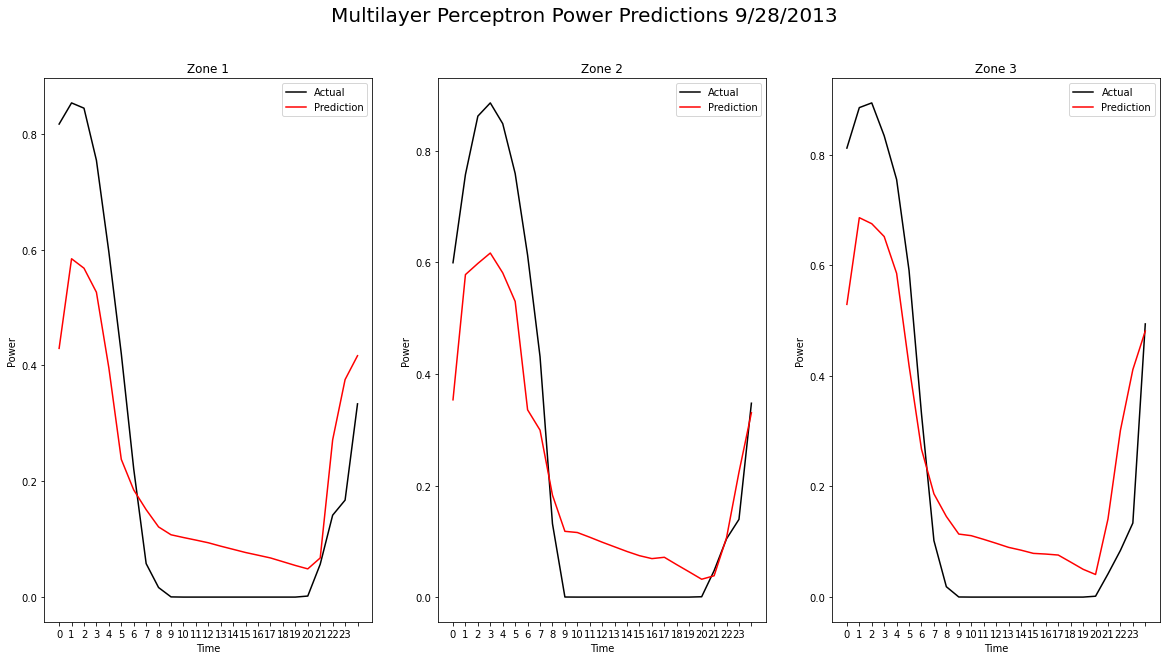

In [69]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20130928 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20130929 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20130928 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20130929 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20130928 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20130929 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
fig.suptitle("Multilayer Perceptron Power Predictions 9/28/2013", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

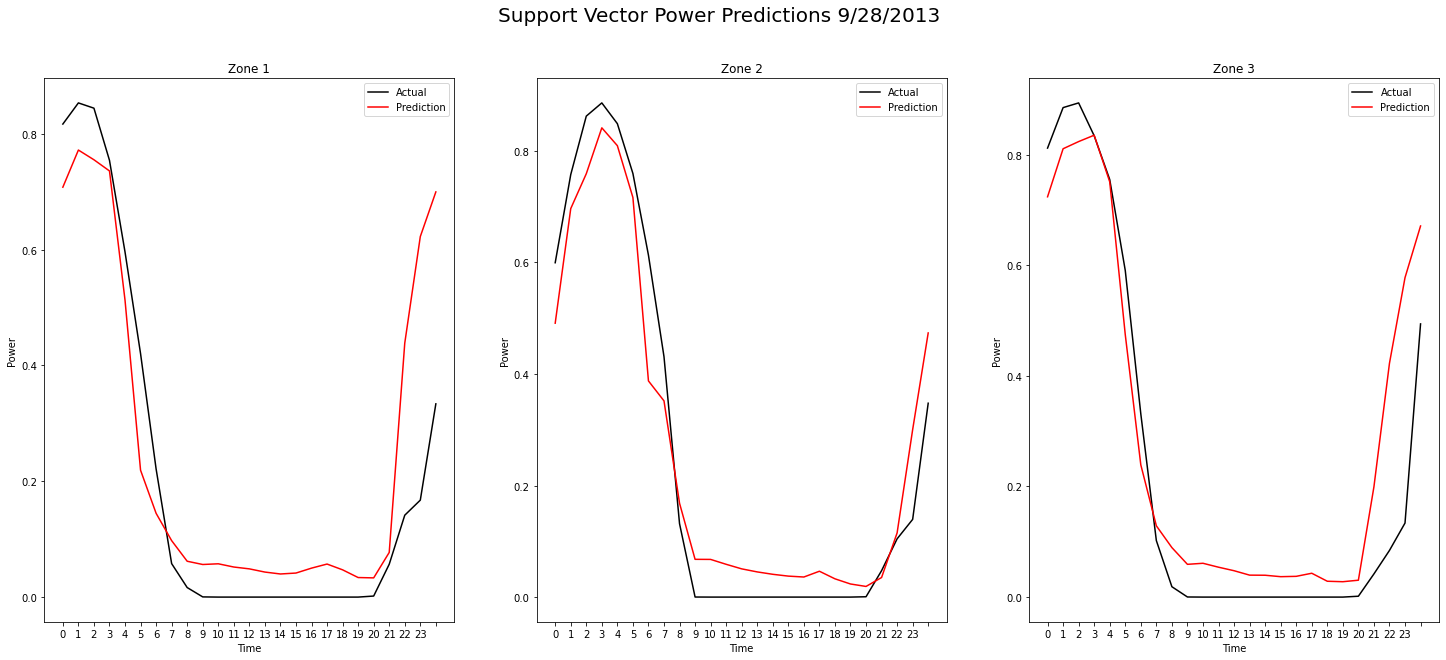

In [70]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20130928 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20130929 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20130928 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20130929 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20130928 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20130929 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("Support Vector Power Predictions 9/28/2013", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

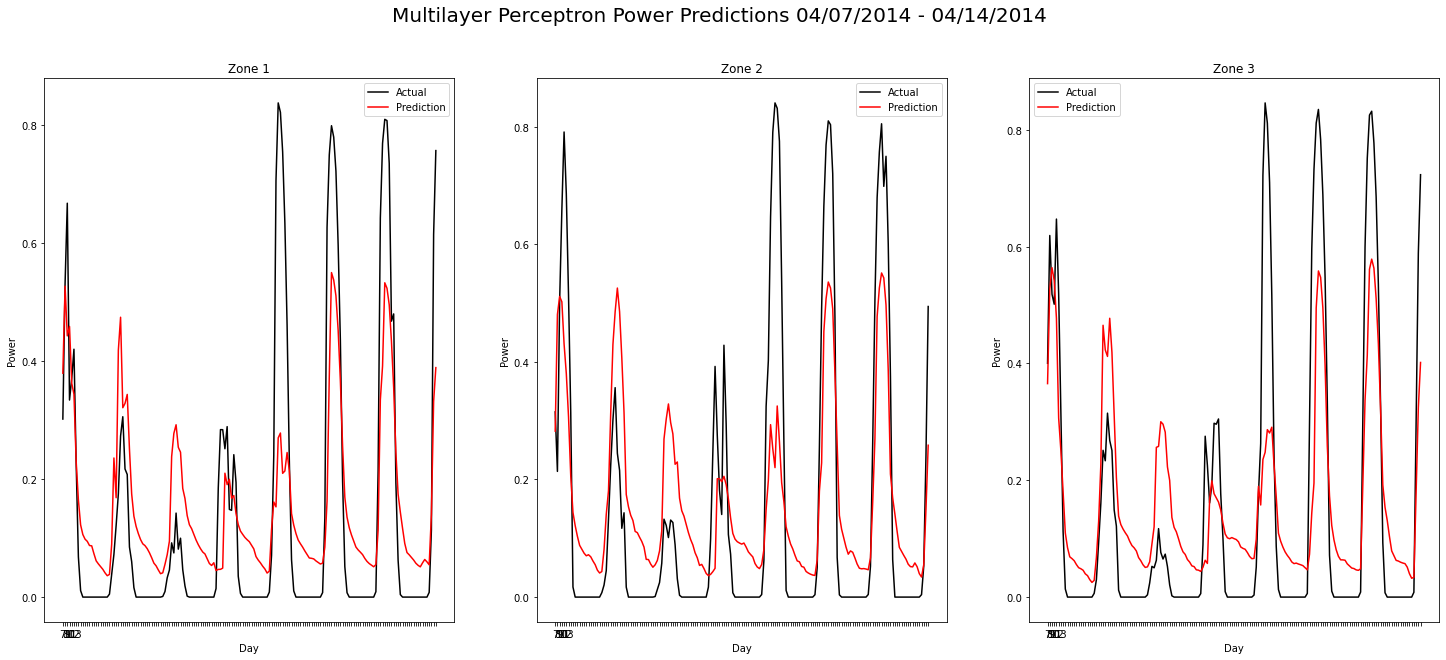

In [71]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20140407 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20140414 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20140407 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20140414 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20140407 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20140414 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("Multilayer Perceptron Power Predictions 04/07/2014 - 04/14/2014", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Day', ylabel= 'Power')
ax1.legend()
x = range(7,14)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Day', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Day', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

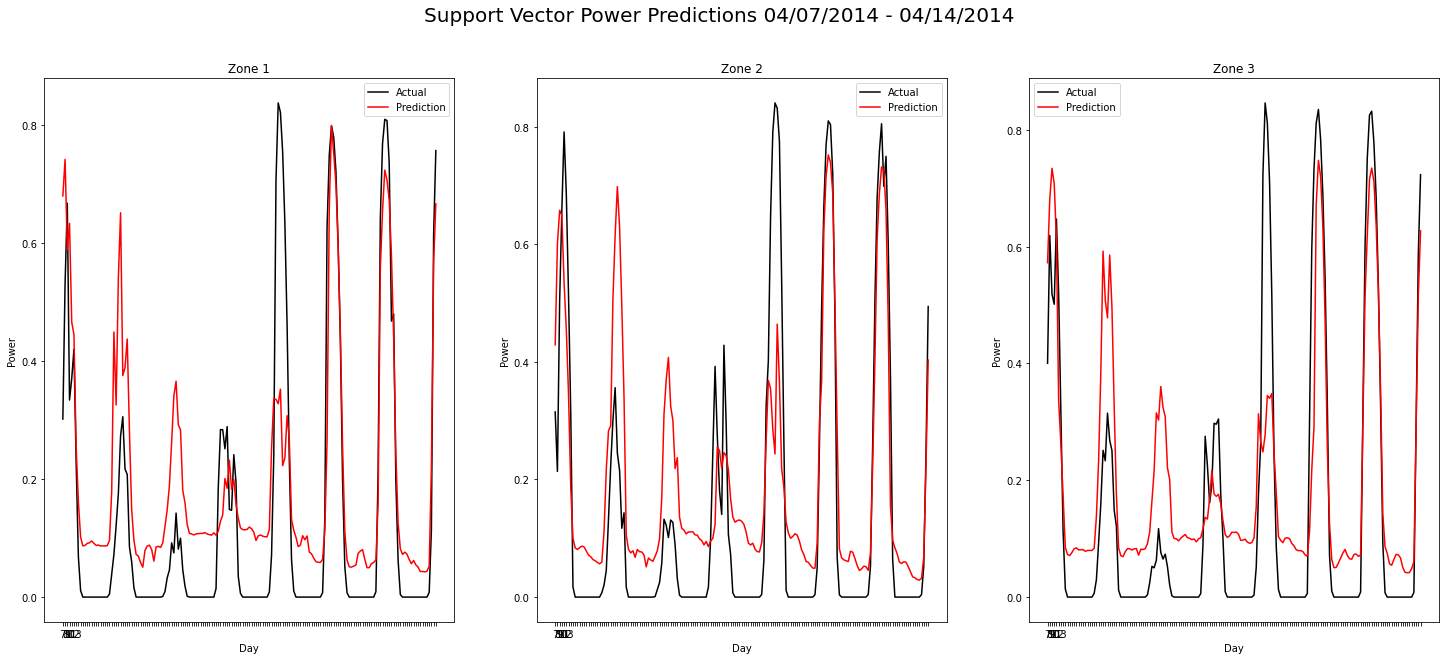

In [72]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20140407 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20140414 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20140407 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20140414 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20140407 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20140414 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("Support Vector Power Predictions 04/07/2014 - 04/14/2014", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Day', ylabel= 'Power')
ax1.legend()
x = range(7,14)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Day', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Day', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")


Text(0.5, 1.0, 'Zone 3')

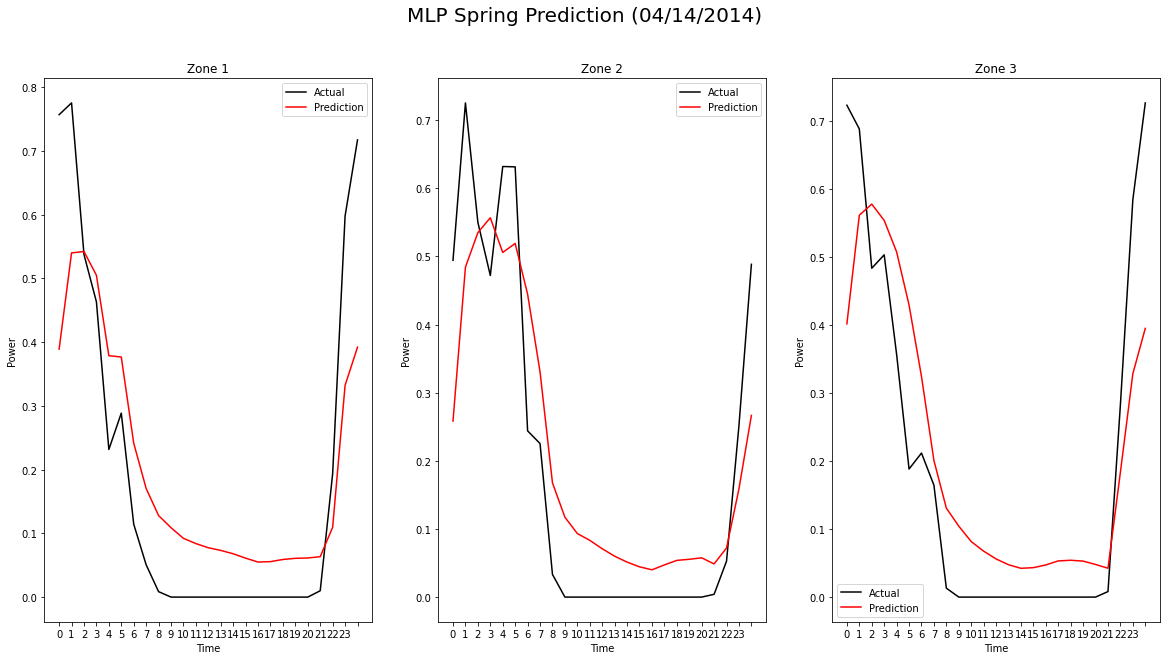

In [73]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20140414 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20140415 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20140414 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20140415 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20140414 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20140415 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
fig.suptitle("MLP Spring Prediction (04/14/2014)", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

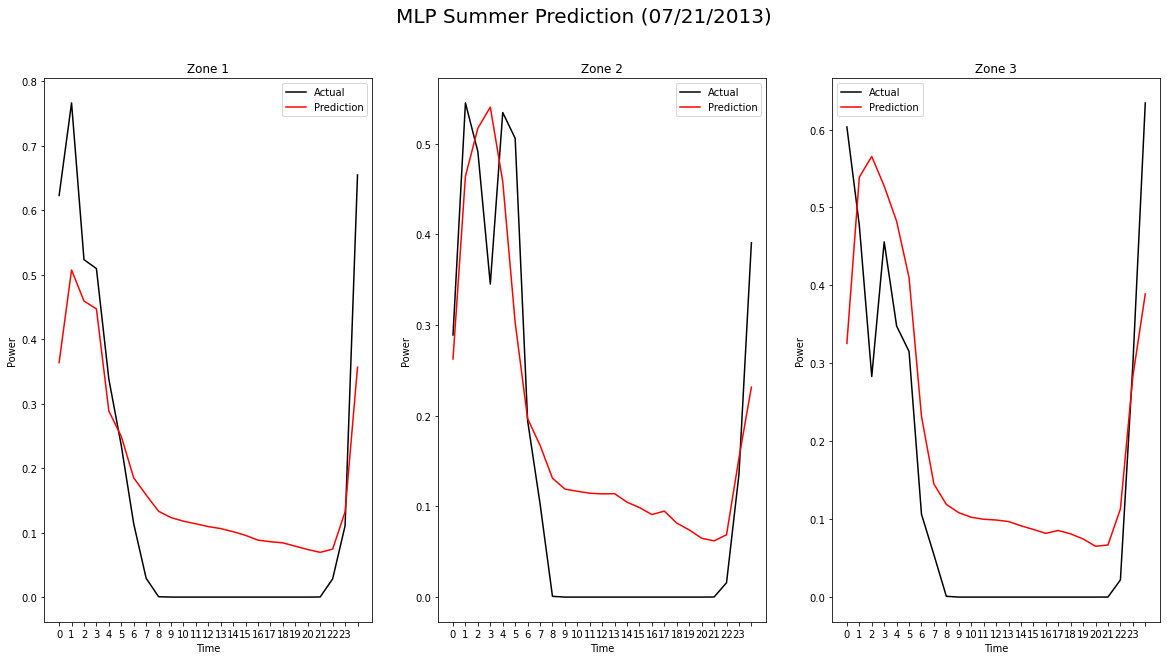

In [74]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20130721 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20130722 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20130721 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20130722 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20130721 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20130722 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
fig.suptitle("MLP Summer Prediction (07/21/2013)", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

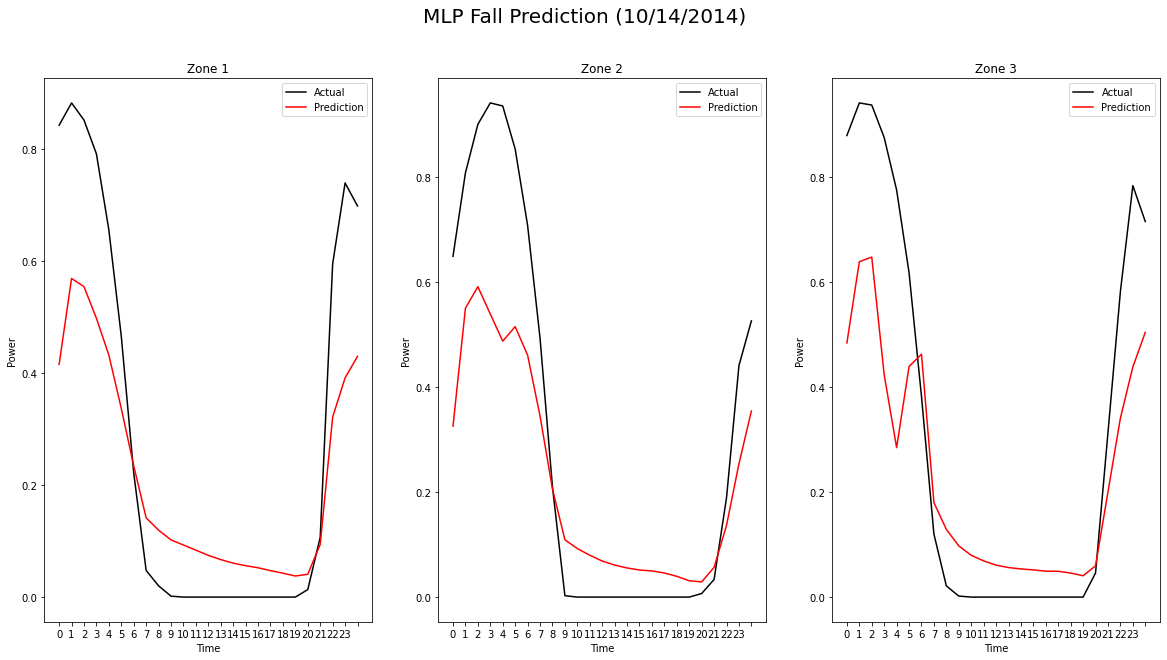

In [75]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20131014 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20131015 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20131014 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20131015 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20131014 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20131015 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
fig.suptitle("MLP Fall Prediction (10/14/2014)", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

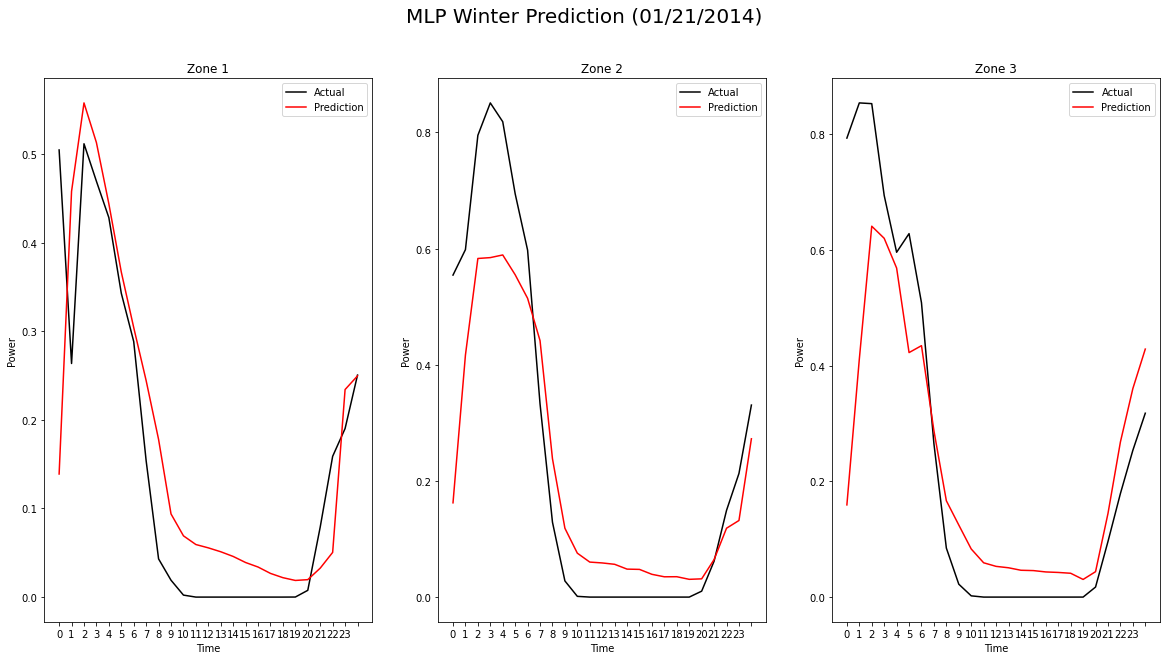

In [76]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20140121 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20140122 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20140121 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20140122 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20140121 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20140122 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
fig.suptitle("MLP Winter Prediction (01/21/2014)", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

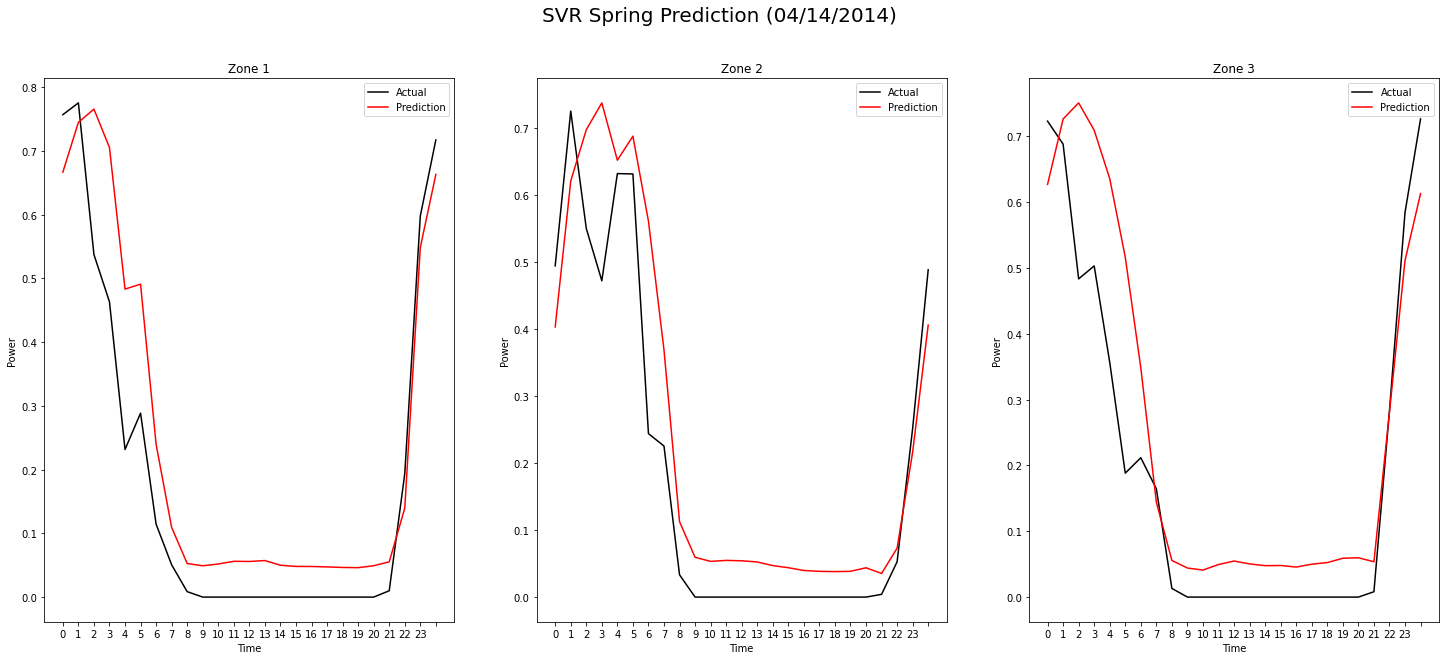

In [77]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20140414 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20140415 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20140414 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20140415 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20140414 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20140415 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("SVR Spring Prediction (04/14/2014)", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

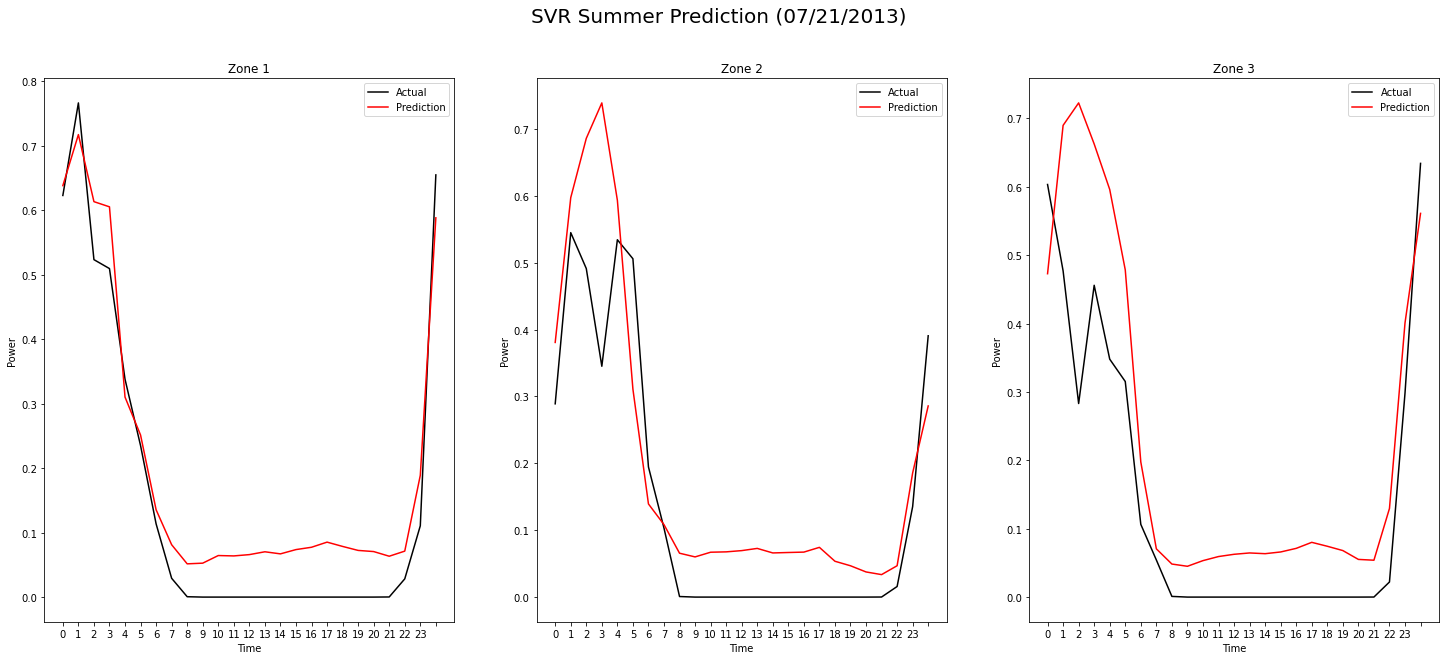

In [78]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20130721 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20130722 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20130721 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20130722 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20130721 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20130722 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("SVR Summer Prediction (07/21/2013)", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

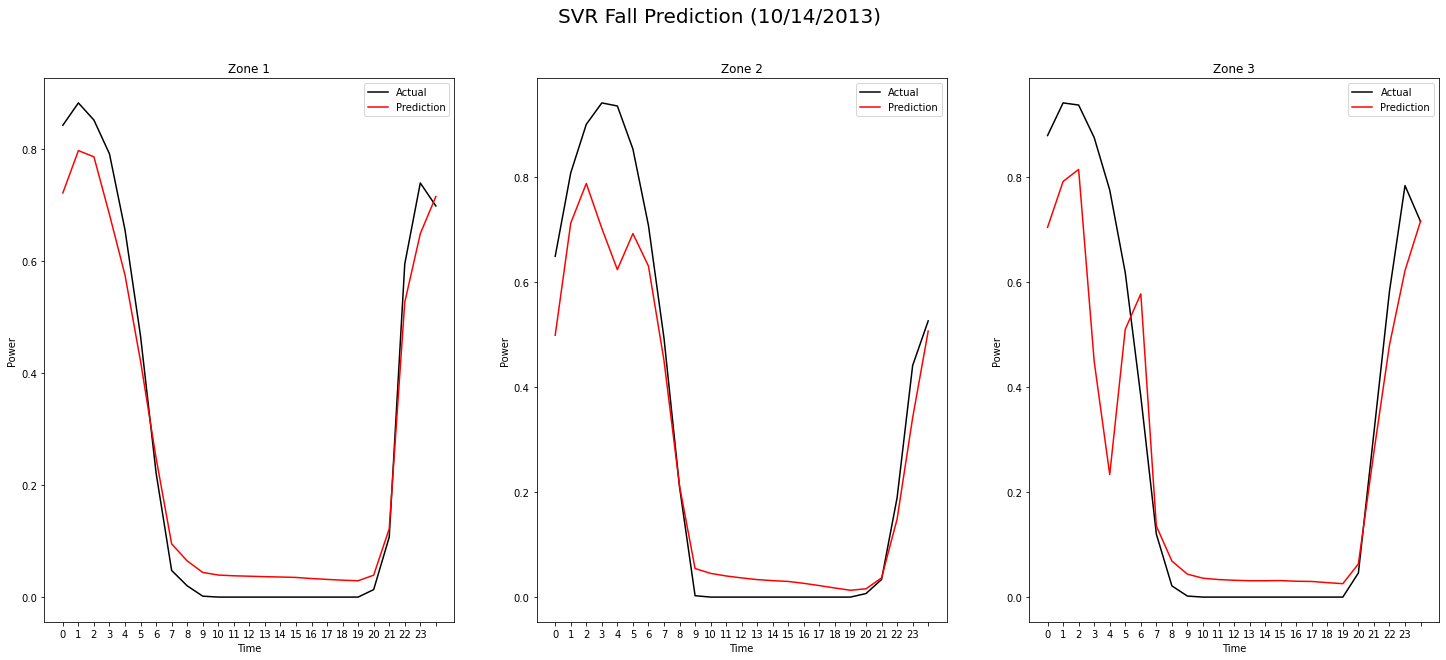

In [79]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20131014 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20131015 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20131014 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20131015 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20131014 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20131015 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("SVR Fall Prediction (10/14/2013)", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

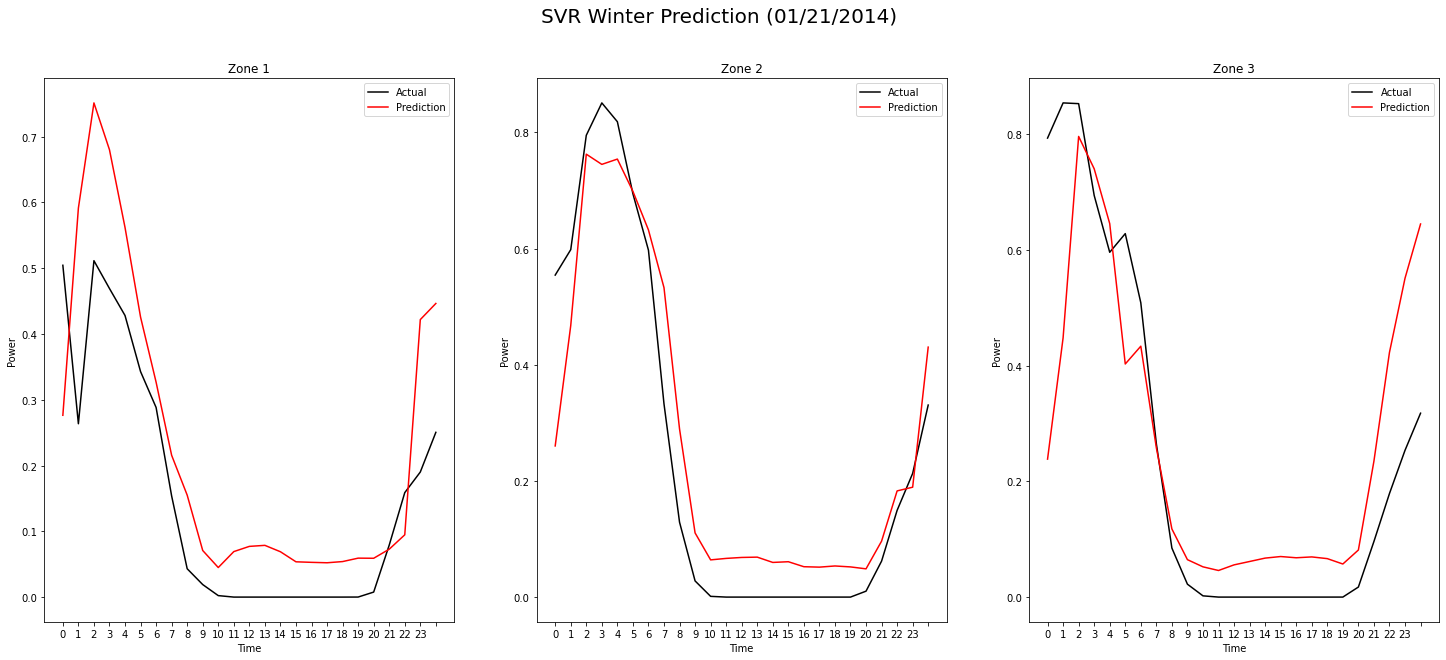

In [80]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20140121 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20140122 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20140121 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20140122 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20140121 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20140122 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("SVR Winter Prediction (01/21/2014)", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Remove current power variable and rerun training to see impact on results

In [81]:
#Remove previous power from data to see difference in results
X_train1 = pd.DataFrame(X_train1)
X_train1 = X_train1.iloc[:,:-1]

X_test1 = pd.DataFrame(X_test1)
X_test1 = X_test1.iloc[:,:-1]

X_train2 = pd.DataFrame(X_train2)
X_train2 = X_train2.iloc[:,:-1]

X_test2 = pd.DataFrame(X_test2)
X_test2 = X_test2.iloc[:,:-1]

X_train3 = pd.DataFrame(X_train3)
X_train3 = X_train3.iloc[:,:-1]

X_test3 = pd.DataFrame(X_test3)
X_test3 = X_test3.iloc[:,:-1]

In [82]:
reg = MLPRegressor()
reg.fit(X_train1 ,y_train1)
y_pred1 = reg.predict(X_test1)

mlp_result1 = pd.DataFrame({'TIMESTAMP': Z1_times, 'Actual': y_test1, 'Prediction': y_pred1})


#Mean Absolute error
MAE1 = mean_absolute_error(y_test1, y_pred1)
print("Zone 1 Mean Absolute Error:", MAE1)
#Root mean squared error
RMSE1 = mean_squared_error(y_test1, y_pred1)
print("Zone 1 Root Mean Squared Error:", RMSE1, '\n')


#Zone2
reg = MLPRegressor()
reg.fit(X_train2 ,y_train2)
y_pred2 = reg.predict(X_test2)

mlp_result2 = pd.DataFrame({'TIMESTAMP': Z2_times, 'Actual': y_test2, 'Prediction': y_pred2})


#Mean Absolute error
MAE2 = mean_absolute_error(y_test2, y_pred2)
print("Zone 2 Mean Absolute Error:", MAE2)
#Root mean squared error
RMSE2 = mean_squared_error(y_test2, y_pred2)
print("Zone 2 Root Mean Squared Error:", RMSE2, '\n')



#Zone 3
reg = MLPRegressor()
reg.fit(X_train3 ,y_train3)
y_pred3 = reg.predict(X_test3)

mlp_result3 = pd.DataFrame({'TIMESTAMP': Z3_times, 'Actual': y_test3, 'Prediction': y_pred3})


#Mean Absolute error
MAE3 = mean_absolute_error(y_test3, y_pred3)
print("Zone 3 Mean Absolute Error:", MAE3)
#Root mean squared error
RMSE3 = mean_squared_error(y_test3, y_pred3)
print("Zone 3 Root Mean Squared Error:", RMSE3, '\n')

avgMAE = (MAE1 + MAE2 + MAE3)/3
avgRMSE = (RMSE1 + RMSE2 + RMSE3)/3
print("Average MAE:", avgMAE)
print("Average RMSE", avgRMSE)

Zone 1 Mean Absolute Error: 0.08211794667327893
Zone 1 Root Mean Squared Error: 0.01745286456770098 

Zone 2 Mean Absolute Error: 0.08790537023856003
Zone 2 Root Mean Squared Error: 0.016954634496901 

Zone 3 Mean Absolute Error: 0.09312301909650586
Zone 3 Root Mean Squared Error: 0.01903439023406373 

Average MAE: 0.08771544533611493
Average RMSE 0.017813963099555238


Text(0.5, 1.0, 'Zone 3')

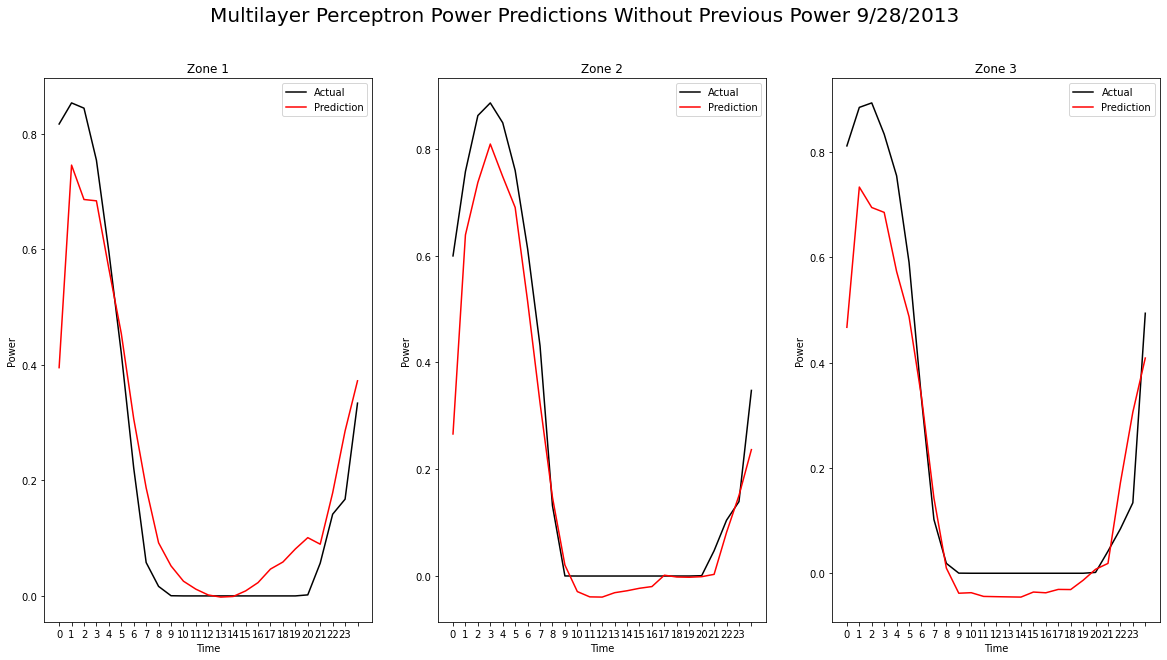

In [83]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20130928 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20130929 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20130928 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20130929 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20130928 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20130929 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
fig.suptitle("Multilayer Perceptron Power Predictions Without Previous Power 9/28/2013", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

In [84]:
#Zone 1
reg = SVR()
reg.fit(X_train1 ,y_train1)
y_pred1 = reg.predict(X_test1)


svr_result1 = pd.DataFrame({'TIMESTAMP': Z1_times, 'Actual': y_test1, 'Prediction': y_pred1})
#print(df_result1.head(20))

#Mean Absolute error
MAE1 = mean_absolute_error(y_test1, y_pred1)
print("Zone 1 Mean Absolute Error:", MAE1)
#Root mean squared error
RMSE1 = mean_squared_error(y_test1, y_pred1)
print("Zone 1 Root Mean Squared Error:", RMSE1, '\n')



#Zone2
reg = SVR()
reg.fit(X_train2 ,y_train2)
y_pred2 = reg.predict(X_test2)

svr_result2 = pd.DataFrame({'TIMESTAMP': Z2_times, 'Actual': y_test2, 'Prediction': y_pred2})
#print(df_result2.head(20))

#Mean Absolute error
MAE2 = mean_absolute_error(y_test2, y_pred2)
print("Zone 2 Mean Absolute Error:", MAE2)
#Root mean squared error
RMSE2 = mean_squared_error(y_test2, y_pred2)
print("Zone 2 Root Mean Squared Error:", RMSE2, '\n')



#Zone 3
reg = SVR()
reg.fit(X_train3 ,y_train3)
y_pred3 = reg.predict(X_test3)

svr_result3 = pd.DataFrame({'TIMESTAMP': Z3_times, 'Actual': y_test3, 'Prediction': y_pred3})
#print(df_result2.head(20)3)

#Mean Absolute error
MAE3 = mean_absolute_error(y_test3, y_pred3)
print("Zone 3 Mean Absolute Error:", MAE3)
#R3oot mean squared error
RMSE3 = mean_squared_error(y_test3, y_pred3)
print("Zone 3 Root Mean Squared Error:", RMSE3, '\n')
avgMAE = (MAE1 + MAE2 + MAE3)/3
avgRMSE = (RMSE1 + RMSE2 + RMSE3)/3
print("Average MAE:", avgMAE)
print("Average RMSE", avgRMSE)

Zone 1 Mean Absolute Error: 0.0946488702902474
Zone 1 Root Mean Squared Error: 0.018441327132091054 

Zone 2 Mean Absolute Error: 0.0949527780747684
Zone 2 Root Mean Squared Error: 0.017961421606674327 

Zone 3 Mean Absolute Error: 0.10043717257039711
Zone 3 Root Mean Squared Error: 0.020529510964514826 

Average MAE: 0.09667960697847096
Average RMSE 0.018977419901093404


Text(0.5, 1.0, 'Zone 3')

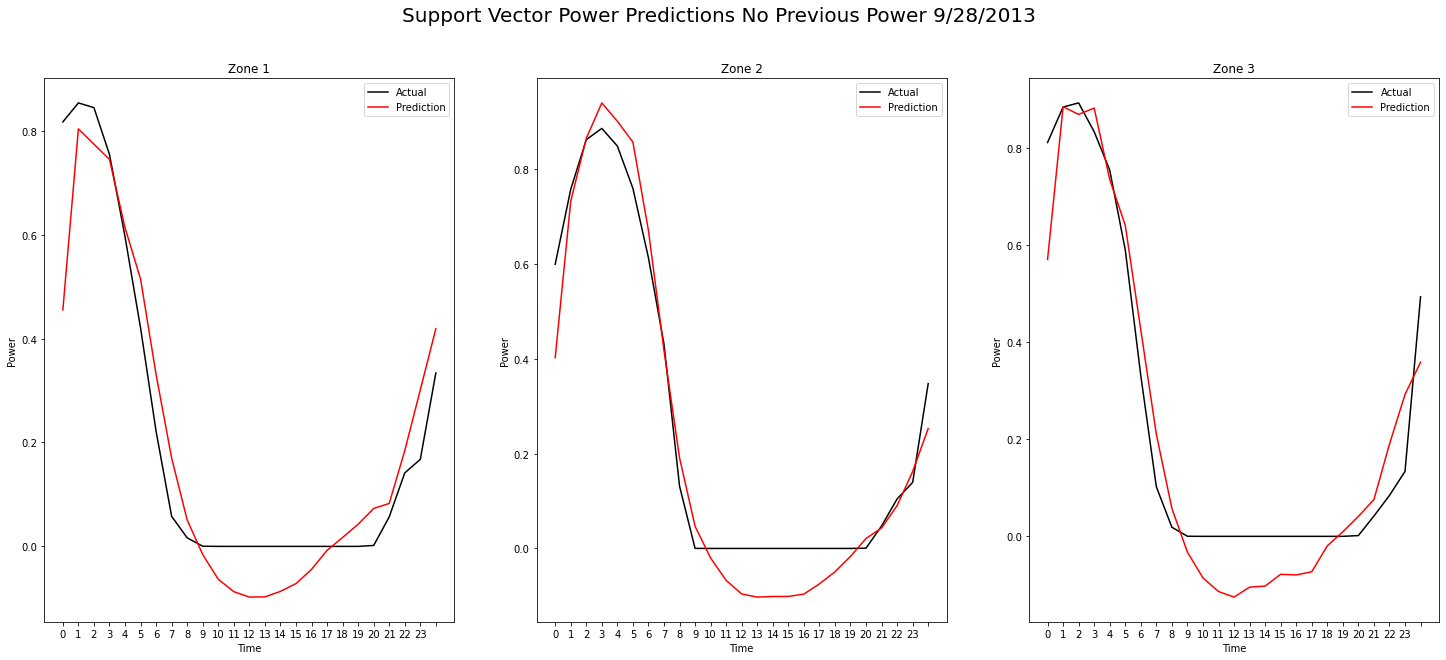

In [85]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20130928 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20130929 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20130928 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20130929 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20130928 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20130929 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("Support Vector Power Predictions No Previous Power 9/28/2013", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Time', ylabel= 'Power')
ax1.legend()
x = range(0,24)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Time', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Time', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

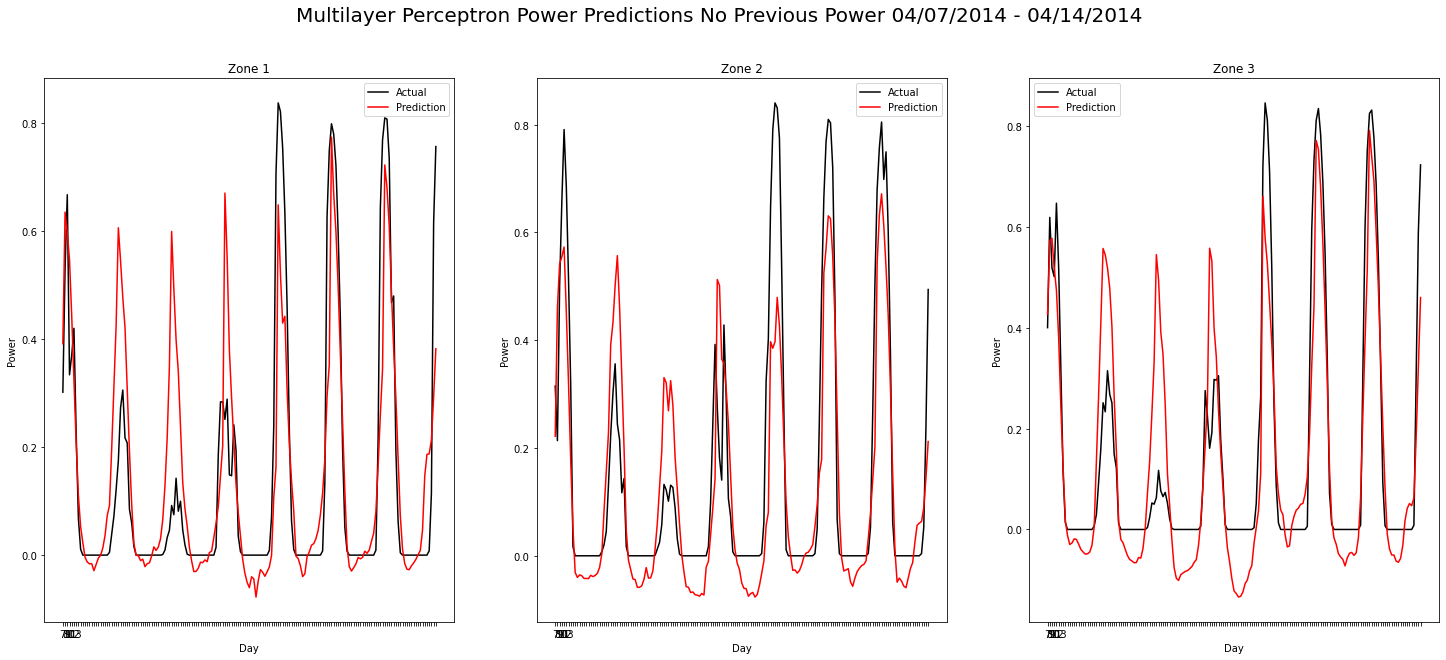

In [86]:
mlpZ1_short = mlp_result1[mlp_result1['TIMESTAMP'] >= '20140407 00:00']
mlpZ1_short = mlpZ1_short[mlpZ1_short['TIMESTAMP'] <= '20140414 00:00']

mlpZ2_short = mlp_result2[mlp_result2['TIMESTAMP'] >= '20140407 00:00']
mlpZ2_short = mlpZ2_short[mlpZ2_short['TIMESTAMP'] <= '20140414 00:00']

mlpZ3_short = mlp_result3[mlp_result3['TIMESTAMP'] >= '20140407 00:00']
mlpZ3_short = mlpZ3_short[mlpZ3_short['TIMESTAMP'] <= '20140414 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("Multilayer Perceptron Power Predictions No Previous Power 04/07/2014 - 04/14/2014", fontsize = 20)
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(mlpZ1_short['TIMESTAMP'], mlpZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Day', ylabel= 'Power')
ax1.legend()
x = range(7,14)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(mlpZ2_short['TIMESTAMP'], mlpZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Day', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(mlpZ3_short['TIMESTAMP'], mlpZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Day', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")

Text(0.5, 1.0, 'Zone 3')

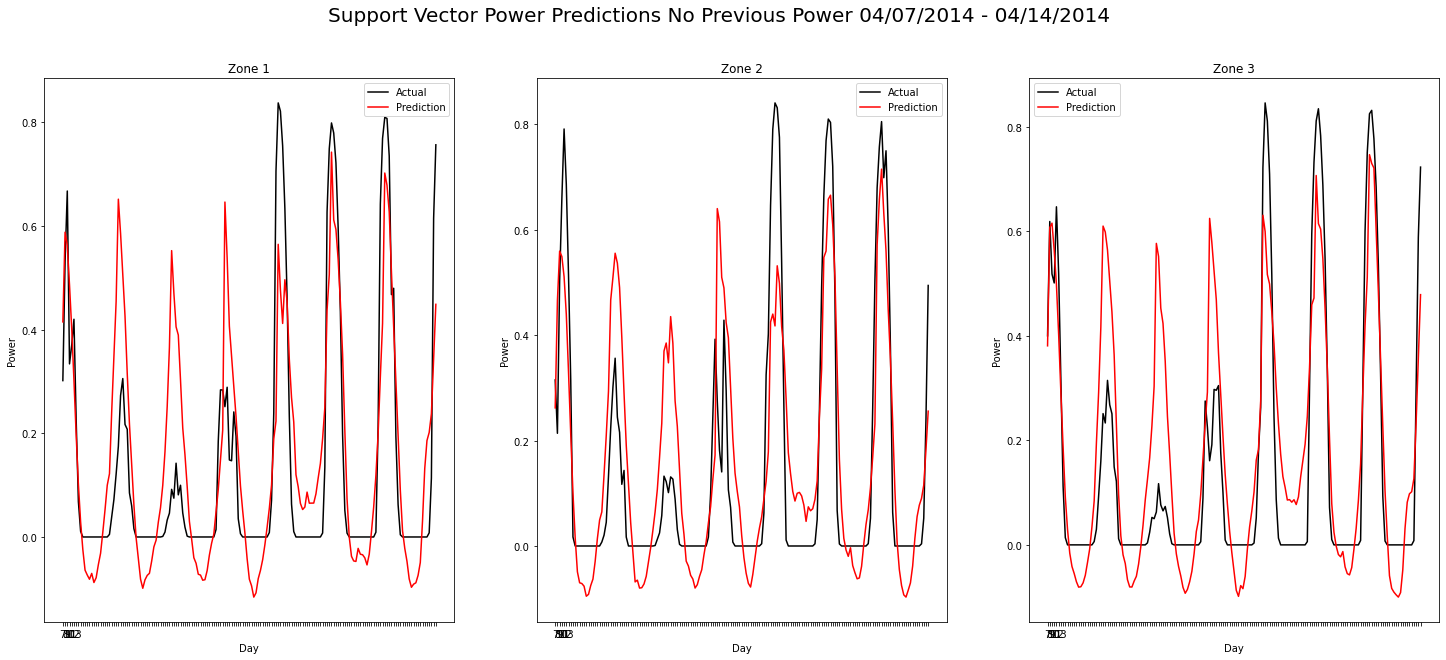

In [87]:
svrZ1_short = svr_result1[svr_result1['TIMESTAMP'] >= '20140407 00:00']
svrZ1_short = svrZ1_short[svrZ1_short['TIMESTAMP'] <= '20140414 00:00']

svrZ2_short = svr_result2[svr_result2['TIMESTAMP'] >= '20140407 00:00']
svrZ2_short = svrZ2_short[svrZ2_short['TIMESTAMP'] <= '20140414 00:00']

svrZ3_short = svr_result3[svr_result3['TIMESTAMP'] >= '20140407 00:00']
svrZ3_short = svrZ3_short[svrZ3_short['TIMESTAMP'] <= '20140414 00:00']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10))
fig.suptitle("Support Vector Power Predictions No Previous Power 04/07/2014 - 04/14/2014", fontsize = 20)
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Actual'], c = 'black', label= 'Actual')
ax1.plot(svrZ1_short['TIMESTAMP'], svrZ1_short['Prediction'], c = 'r', label = 'Prediction')
ax1.set(xlabel = 'Day', ylabel= 'Power')
ax1.legend()
x = range(7,14)
ax1.set_xticklabels(x)
ax1.set_title("Zone 1")

ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Actual'], c = 'black', label= 'Actual')
ax2.plot(svrZ2_short['TIMESTAMP'], svrZ2_short['Prediction'], c = 'r', label = 'Prediction')
ax2.set(xlabel = 'Day', ylabel= 'Power')
ax2.legend()
ax2.set_xticklabels(x)
ax2.set_title("Zone 2")

ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Actual'], c = 'black', label= 'Actual')
ax3.plot(svrZ3_short['TIMESTAMP'], svrZ3_short['Prediction'], c = 'r', label = 'Prediction')
ax3.set(xlabel = 'Day', ylabel= 'Power')
ax3.legend()
ax3.set_xticklabels(x)
ax3.set_title("Zone 3")